# EDA and Initial Analysis

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt
from scipy.sparse import identity
import cleaning
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import pickle
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import joblib

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sagun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sagun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Clean dataset to prep for modeling

In [2]:
cmu_summ_final = cleaning.GenreDataFrame(pd.read_csv('booksummaries.txt', delimiter='\t', names=['Wiki ID','Freebase ID','Title','Author','Pub Date','Genres','Plot Summary']))
cmu_summ_final.remove_names()
pickle.dump(cmu_summ_final, open("save.p","wb"))

In [3]:
cmu_summ_final.df['Sep Genres'] = cmu_summ_final.df['Genres'].str.findall('[A-Z]\w.+?(?="|\\\\)')

Lemmatize all of the summaries

In [5]:
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J":wordnet.ADJ,
               "N":wordnet.NOUN,
               "V":wordnet.VERB,
               "R":wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemma_all(doc):
    var = [lemmatizer.lemmatize(w, get_wordnet_pos((w))) for w in nltk.word_tokenize(doc)]
    return ' '.join(var)

def lemma_col(corpus):
    new_summ = []
    for i in np.arange(len(corpus)):
        new_summ.append(lemma_all(corpus[i]))
    return new_summ

In [72]:
new_summ_col = lemma_col(cmu_summ_final.df['nlpSumm'])
cmu_summ_final.df['finalSumm']=new_summ_col
pickle.dump(cmu_summ_final, open("save2.p","wb"))

In [8]:
cmu = pickle.load(open("save2.p","rb"))
single_row = cmu.single_row()
single_row = single_row.reset_index().drop('index',axis=1)

Create dataframes of genres of form and genres of content, combining to simplier categories of fiction vs nonfiction, and the ten fiction genres used in the analysis

In [15]:
ficnonfic_dict = {'Anthology':'Fiction', 'Comic book':'Fiction', 'Comics':'Fiction','Epistolary novel':'Fiction',
                      'Ergodic literature':'Fiction', 'Experimental literature':'Fiction','Fiction':'Fiction',
                      'First-person narrative':'Fiction', 'Gamebook':'Fiction', 'Graphic novel':'Fiction',
                      'Non-fiction novel':'Fiction', 'Novel':'Fiction', 'Novella':'Fiction','Parallel novel':'Fiction',
                      'Picture book':'Fiction', 'Play':'Fiction', 'Poetry':'Fiction', 'Prose':'Fiction','Prose poetry':'Fiction',
                      'Religious text':'Fiction', 'Role-playing game':'Fiction', 'Serial':'Fiction', 'Short story':'Fiction',
                      'Anthropology':'Non-fiction', 'Autobiographical novel':'Non-fiction', 'Autobiography':'Non-fiction', 
                      'Biographical novel':'Non-fiction', 'Biography':'Non-fiction', 'Business':'Non-fiction',
                      'Computer Science':'Non-fiction', 'Creative nonfiction':'Non-fiction', 'Economics':'Non-fiction',
                      'Essay':'Non-fiction', 'Literary criticism':'Non-fiction', 'Mathematics':'Non-fiction',
                      'Memoir':'Non-fiction', 'Neuroscience':'Non-fiction', 'Non-fiction':'Non-fiction', 
                      'Personal journal':'Non-fiction', 'Philosophy':'Non-fiction', 'Photography':'Non-fiction',
                      'Political philosophy':'Non-fiction', 'Popular culture':'Non-fiction', 'Popular science':'Non-fiction',
                      'Science':'Non-fiction', 'Sociology':'Non-fiction', 'Spirituality':'Non-fiction',
                      'Sports':'Non-fiction', 'Travel literature':'Non-fiction', 'Treatise':'Non-fiction'}

form_df = pd.DataFrame.from_dict(ficnonfic_dict, orient='index')
form_df = form_df.reset_index()
form_df.columns = ['Forms','FicNonfic']
fic_nonfic_df = single_row.merge(form_df, left_on='genre', right_on='Forms', how='outer')
fic_nonfic_df = fic_nonfic_df.dropna()

In [16]:
com_genre_dict = {'Adventure':'Adventure','Adventure novel':'Adventure', 'Naval Adventure':'Adventure',
                      'Alternate history':'Alternate history',
                      "Children's literature":"Children's literature","Boys' school stories":"Children's literature",
                      'Juvenile fantasy':"Children's literature",
                      'Comedy':'Comedy', 'Satire':'Comedy','Farce':'Comedy','Comedy of manners':'Comedy','Parody':'Comedy',
                      'Tragic comedy':'Comedy','Black comedy':'Comedy','Comic novel':'Comedy',
                      'Crime fiction':'Crime fiction', 'Cozy':'Crime fiction',
                      'Detective fiction':'Detective fiction', 'Hardboiled':'Detective fiction',
                      'Police procedural':'Detective fiction',
                      'Spy fiction':'Spy fiction','Cabal':'Spy fiction',
                      'Fantasy':'Fantasy','Bangsian fantasy':'Fantasy','Comic fantasy':'Fantasy','Contemporary fantasy':'Fantasy',
                      'Dark fantasy':'Fantasy','Fantasy of manners':'Fantasy','Heroic fantasy':'Fantasy','High fantasy':'Fantasy',
                      'Historical fantasy':'Fantasy','Low fantasy':'Fantasy','Magic realism':'Fantasy','Sword and sorcery':'Fantasy',
                      'Urban fantasy':'Fantasy',
                      'Historical fiction':'Historical fiction','Historical novel':'Historical fiction',
                      'Historical whodunnit':'Historical fiction','Wuxia':'Historical fiction',
                      'Horror':'Horror','American Gothic Fiction':'Horror','Gothic fiction':'Horror','Vampire fiction':'Horror',
                      'Zombie':'Horror','Zombies in popular culture':'Horror',
                      'Mystery':'Mystery','Whodunit':'Mystery','Locked room mystery':'Mystery',
                      'Romance novel':'Romance','Chivalric romance':'Romance','Colonial United States romance':'Romance',
                      'Elizabthan romance':'Romance','Georgian romance':'Romance','Historical romance':'Romance',
                      'Medieval romance':'Romance','Regency romance':'Romance','Romantic comedy':'Romance',
                      'Paranormal romance':'Romance',
                      'Science Fiction':'Science fiction','Alien invasion':'Science fiction','Comic science fiction':'Science fiction',
                      'Cyberpunk':'Science fiction','Dying Earth subgenre':'Science fiction','Edisonade':'Science fiction',
                      'Feminist science fiction':'Science fiction','Future history':'Science fiction','Hard science fiction':'Science fiction',
                      'Human extinction':'Science fiction','Invasion literature':'Science fiction','Military science fiction':'Science fiction',
                      'Planetary romance':'Science fiction','Postcyberpunk':'Science fiction','Scientific romance':'Science fiction',
                      'Social science fiction':'Science fiction','Soft science fiction':'Science fiction','Space opera':'Science fiction',
                      'Sword and planet':'Science fiction','Time travel':'Science fiction',
                      'Apocalyptic and post-apocalyptic fiction':'Science fiction','Biopunk':'Science fiction','Steampunk':'Science fiction',
                      'Subterranean fiction':'Science fiction',
                      'Speculative fiction':'Speculative fiction','Dystopia':'Speculative fiction','Superhero fiction':'Speculative fiction',
                      'Supernatural':'Speculative fiction','Ghost story':'Speculative fiction','Utopian and dystopian fiction':'Speculative fiction',
                      'Utopian fiction':'Speculative fiction',
                      'Suspense':'Suspense',
                      'Thriller':'Thriller','Techno-thriller':'Thriller','Conspiracy':'Thriller','Conspiracy fiction':'Thriller',
                      'Young adult literature':'Young adult literature', 'Bildungsroman':'Young adult literature',
                      'Coming of age':'Young adult literature','English public-school stories':'Young adult literature',
                      'School story':'Young adult literature','Light novel':'Young adult literature'}

com_genre_df = pd.DataFrame.from_dict(com_genre_dict, orient='index')
com_genre_df = com_genre_df.reset_index()
com_genre_df.columns = ['Subgenres','Genre']
fic_genres_df = single_row.merge(com_genre_df, left_on='genre', right_on='Subgenres', how='outer')
fic_genres_df = fic_genres_df.dropna()

## EDA for whole set

### Build full genre list

In [17]:
genre_list = single_row['genre']
genre_list = set(genre_list)
genre_list = list(genre_list)

In [18]:
genre_dict = dict.fromkeys(genre_list,0)

In [19]:
for i in single_row['genre'][1:]:
    genre_dict[i]=genre_dict[i]+1

### Use genre list to for all genres and plot

In [24]:
genres_df = pd.DataFrame.from_dict(genre_dict, orient='index')
genres_df = genres_df.reset_index()
genres_df.columns = ['Genre', 'Count']

Text(0, 0.5, 'Count')

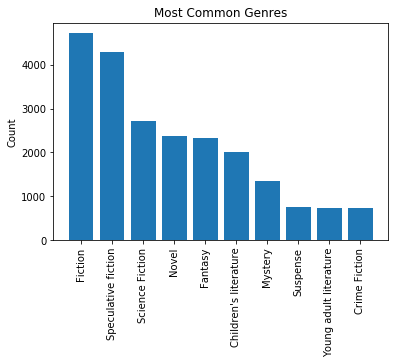

In [25]:
plt.bar(genres_df.sort_values('Count', ascending=False).head(10)['Genre'],genres_df.sort_values('Count', ascending=False).head(10)['Count'])
plt.xticks(rotation=90)
plt.title('Most Common Genres')
plt.ylabel('Count')

### Genre graph without form-based labels

In [27]:
genre_den = genres_df.merge(com_genre_df, left_on='Genre', right_on='Subgenres', how='inner').drop(['Subgenres','Genre_x'],axis=1)
genre_den['Total'] = genre_den.groupby('Genre_y')['Count'].transform('sum')
genre_den = genre_den.drop('Count',axis=1).drop_duplicates('Genre_y')

Text(0.5, 1.0, 'Most Common by Genre')

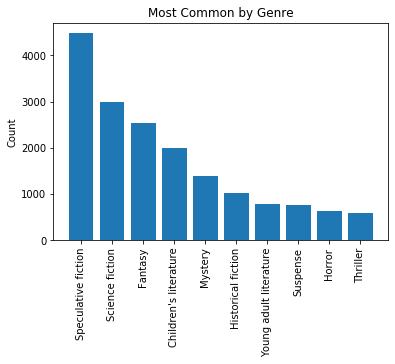

In [28]:
plt.bar(genre_den.sort_values('Total', ascending=False).head(10)['Genre_y'],genre_den.sort_values('Total', ascending=False).head(10)['Total'])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Most Common by Genre')

### Genre graph from form (just fiction vs nonfiction)

In [29]:
genre_form = genres_df.merge(form_df, left_on='Genre', right_on='Forms', how='inner').drop(['Forms','Genre'],axis=1)
genre_form['Total'] = genre_form.groupby('FicNonfic')['Count'].transform('sum')
genre_form = genre_form.drop('Count',axis=1).drop_duplicates('FicNonfic')

Text(0.5, 1.0, 'Fiction vs Non-fiction')

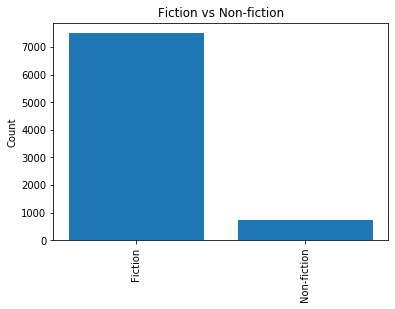

In [30]:
plt.bar(genre_form.sort_values('Total', ascending=False).head(10)['FicNonfic'],genre_form.sort_values('Total', ascending=False).head(10)['Total'])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Fiction vs Non-fiction')

### Length of Summaries

In [31]:
cmu_summ_final.df['nlpSumm']
summ_len_dict = {}
for i in np.arange(0,len(cmu_summ_final.df['nlpSumm'])):
    summ_len_dict[i] = len(cmu_summ_final.df['nlpSumm'][i])
summ_len_df = pd.DataFrame.from_dict(summ_len_dict,orient='index')

Text(0.5, 0, 'Word Count')

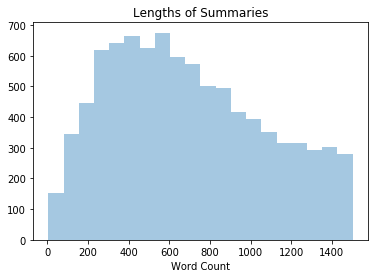

In [33]:
sns.distplot(summ_len_df.sort_values(by=0).head(9000), kde=False, bins=20)
plt.title('Lengths of Summaries')
plt.xlabel('Word Count')

## Naive Bayes Modeling on Each Genre, including Indicative Words

#### Non fiction vs fiction

In [34]:
def good_bad_words(vectorizer, test_X1, NB):
    words = np.array(vectorizer.get_feature_names())
    x = identity(test_X1.shape[1])
    probs = NB.predict_log_proba(x)[:,0]
    ind = np.argsort(probs)
    
    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]
    bad_words = bad_words[::-1]
    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    bad_prob = bad_prob[::-1]
    
    return good_words, bad_words, good_prob, bad_prob

In [35]:
def print_words(good_words, bad_words, good_prob, bad_prob,name_cat_1,name_cat_2):
    print(name_cat_2)
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    print("\t")
    print(name_cat_1)
    for w,p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    print("\t")

In [36]:
def naive_bayes_cmufunc(full_df,column_y,minval,alpha_nb=1):
    full_df['id']=full_df[column_y].factorize()[0]
    cat_id_df = full_df[[column_y,'id']].drop_duplicates().sort_values('id')
    
    X = full_df['finalSumm']
    y = full_df['id']
    train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)
    
    vectorizer = CountVectorizer(stop_words = 'english', min_df = minval)
    train_X1 = vectorizer.fit_transform(train_X)
    test_X1 = vectorizer.transform(test_X)
    vectorizer2 = TfidfVectorizer(stop_words='english', min_df = minval)
    train_X2 = vectorizer2.fit_transform(train_X)
    test_X2 = vectorizer2.transform(test_X)

    NB = MultinomialNB(alpha=alpha_nb)
    NB.fit(train_X1,train_y)
    NB2 = MultinomialNB(alpha=alpha_nb)
    NB2.fit(train_X2, train_y)

    accuracy_train1 = NB.score(train_X1,train_y)
    accuracy_train2 = NB2.score(train_X2,train_y)
    accuracy1 = NB.score(test_X1,test_y)
    accuracy2 = NB2.score(test_X2,test_y)
    words_1 = good_bad_words(vectorizer, test_X1, NB)
    words_2 = good_bad_words(vectorizer2, test_X2, NB2)
    
    return accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df, NB, NB2,vectorizer,vectorizer2

In [37]:
def genre_reduce(genre_df,col_name,col_type):
    df1 = genre_df[genre_df[col_name]==col_type]
    df2 = genre_df[genre_df[col_name]!=col_type]
    df2 = df2.sample(n=len(df1),random_state=42)
    together = df1.append(df2)
    return together

In [38]:
ficnonficfin_df = genre_reduce(fic_nonfic_df,"FicNonfic","Non-fiction")

In [41]:
[accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df, NB, NB2,c_vect,t_vect] = naive_bayes_cmufunc(ficnonficfin_df,'FicNonfic',0.05)
cmu_summ_ficnonfic = {'Training Accuracy':{'Count':accuracy_train1,'Tfidf':accuracy_train2},
                      'Testing Accuracy':{'Count':accuracy1,'Tfidf':accuracy2},
                      'Words':{'Count':words_1,'Tfidf':words_1},
                      'factorize info':cat_id_df,
                      'count_model':NB,
                      'tfidf_model':NB2,
                      'count_vect':c_vect,
                      'tfidf_vect':t_vect}

View the indicative words of the nonfiction vs. fiction split, both with the tfidf and count vectorizers

In [42]:
cmu_summ_ficnonfic['Words']['Count']
g1 = cmu_summ_ficnonfic['Words']['Count'][0]
b1 = cmu_summ_ficnonfic['Words']['Count'][1]
gp1 = cmu_summ_ficnonfic['Words']['Count'][2]
bp1 = cmu_summ_ficnonfic['Words']['Count'][3]

In [43]:
print_words(g1,b1,gp1,bp1,'Fiction Words', 'Non Fiction Words')

Non Fiction Words
              argues 0.93
              theory 0.91
             chapter 0.88
             example 0.86
           describes 0.82
              author 0.81
             subject 0.80
               issue 0.80
          individual 0.79
               spent 0.79
	
Fiction Words
                ship 0.10
             reveals 0.19
           discovers 0.20
          mysterious 0.21
              refuse 0.22
              battle 0.22
                kill 0.22
          apparently 0.23
              agrees 0.23
              rescue 0.23
	


In [44]:
cmu_summ_ficnonfic['Words']['Tfidf']
g2 = cmu_summ_ficnonfic['Words']['Tfidf'][0]
b2 = cmu_summ_ficnonfic['Words']['Tfidf'][1]
gp2 = cmu_summ_ficnonfic['Words']['Tfidf'][2]
bp2 = cmu_summ_ficnonfic['Words']['Tfidf'][3]

In [45]:
print_words(g2,b2,gp2,bp2,'Non Fic Words', 'Fic Words')

Fic Words
              argues 0.93
              theory 0.91
             chapter 0.88
             example 0.86
           describes 0.82
              author 0.81
             subject 0.80
               issue 0.80
          individual 0.79
               spent 0.79
	
Non Fic Words
                ship 0.10
             reveals 0.19
           discovers 0.20
          mysterious 0.21
              refuse 0.22
              battle 0.22
                kill 0.22
          apparently 0.23
              agrees 0.23
              rescue 0.23
	


 #### Fiction genres

In [51]:
def genre_group(summ_df, genre, non_genre,new_col, non_after=False):
    fic_summ = summ_df.drop(['genre','Subgenres'], axis=1)
    fic_summ.loc[fic_summ['Genre']==genre, new_col] = genre
    fic_summ.loc[fic_summ['Genre']!=genre, new_col] = non_genre
    fic_summ = fic_summ.sort_values(new_col, ascending=non_after).drop_duplicates('Title')
    return fic_summ

In [52]:
fic_spec = genre_group(fic_genres_df, 'Speculative fiction','NonSpec','SpecFic')
fic_scifi = genre_group(fic_genres_df, 'Science fiction','NonSci','SciFi')
fic_fan = genre_group(fic_genres_df, 'Fantasy','NonFan','Fantasy', non_after=True)
fic_child = genre_group(fic_genres_df, "Children's literature",'NonChild','Child', non_after=True)
fic_mys = genre_group(fic_genres_df, 'Mystery','NonMys','Mystery', non_after=True)
fic_hist = genre_group(fic_genres_df, 'Historical fiction','NonHist','Hist', non_after=True)
fic_you = genre_group(fic_genres_df, 'Young adult literature','NonYou','Young')
fic_sus = genre_group(fic_genres_df, 'Suspense','NonSus','Susp')
fic_hor = genre_group(fic_genres_df, 'Horror','NonHor','Horror', non_after=True)
fic_thr = genre_group(fic_genres_df, 'Thriller','NonThr','Thriller')

In [53]:
fic_spec2 = fic_spec #this particular set already almost has parody, so it doesn't get reduced
fic_scifi2 = genre_reduce(fic_scifi,'SciFi','Science fiction')
fic_fan2 = genre_reduce(fic_fan,'Fantasy','Fantasy')
fic_child2 = genre_reduce(fic_child,'Child',"Children's literature")
fic_mys2 = genre_reduce(fic_mys,'Mystery','Mystery')
fic_hist2 = genre_reduce(fic_hist,'Hist','Historical fiction')
fic_you2 = genre_reduce(fic_you,'Young','Young adult literature')
fic_sus2 = genre_reduce(fic_sus,'Susp','Suspense')
fic_hor2 = genre_reduce(fic_hor,'Horror','Horror')
fic_thr2 = genre_reduce(fic_thr,'Thriller','Thriller')

In [54]:
def naive_bayes_dict(df,column,mindf_val,alpha_nb=1):
    [accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df,NB,NB2,c_vect,t_vect] = naive_bayes_cmufunc(df,column,mindf_val,alpha_nb)
    final_dict = {'Training Accuracy':{'Count':accuracy_train1,'Tfidf':accuracy_train2},
                      'Testing Accuracy':{'Count':accuracy1,'Tfidf':accuracy2},
                      'Words':{'Count':words_1,'Tfidf':words_1},
                      'factorize info':cat_id_df,
                      'count_model':NB,
                      'tfidf_model':NB2,
                      'count_vect':c_vect,
                      'tfidf_vect':t_vect}
    return final_dict

Note that the min_df value was chosen via cross validation at an earlier point, hence the values seen in the models below. It was also restricted to the range from 0.01 to 0.01, to keep the dictionary as large as possible

In [55]:
cmu_summ_specfic = naive_bayes_dict(fic_spec2,'SpecFic',0.02)
cmu_summ_scifi = naive_bayes_dict(fic_scifi2, 'SciFi',0.02)
cmu_summ_fan = naive_bayes_dict(fic_fan2, 'Fantasy',0.05)
cmu_summ_child = naive_bayes_dict(fic_child2, 'Child',0.07)
cmu_summ_mys = naive_bayes_dict(fic_mys2, 'Mystery',0.03)
cmu_summ_hist = naive_bayes_dict(fic_hist2, 'Hist',0.04)
cmu_summ_you = naive_bayes_dict(fic_you2, 'Young',0.02)
cmu_summ_sus = naive_bayes_dict(fic_sus2, 'Susp',0.04)
cmu_summ_hor = naive_bayes_dict(fic_hor2, 'Horror',0.09)
cmu_summ_thr = naive_bayes_dict(fic_thr2, 'Thriller',0.08)

In [56]:
cmu_summ_full = {"Speculative fiction":cmu_summ_specfic,
                "Science fiction": cmu_summ_scifi,
                "Fantasy": cmu_summ_fan,
                "Children's literature":cmu_summ_child,
                "Mystery":cmu_summ_mys,
                "Historical fiction":cmu_summ_hist,
                "Young adult literature":cmu_summ_you,
                "Suspense":cmu_summ_sus,
                "Horror":cmu_summ_hor,
                "Thriller":cmu_summ_thr,
                "FicnonFic":cmu_summ_ficnonfic}

Pickle the models for future use (pickle for internal use, joblib for website)

In [57]:
pickle.dump(cmu_summ_full, open("nb_builds.p","wb"))
joblib.dump(cmu_summ_full, 'nb_builds.p')

Indicative Words for all fiction genres

In [58]:
def print_words_all(summ_dict, not_label, label):
    g1 = summ_dict['Words']['Count'][0]
    b1 = summ_dict['Words']['Count'][1]
    gp1 = summ_dict['Words']['Count'][2]
    bp1 = summ_dict['Words']['Count'][3]

    print_words(g1,b1,gp1,bp1,not_label,label)
    
    g2 = summ_dict['Words']['Tfidf'][0]
    b2 = summ_dict['Words']['Tfidf'][1]
    gp2 = summ_dict['Words']['Tfidf'][2]
    bp2 = summ_dict['Words']['Tfidf'][3]

    print_words(g2,b2,gp2,bp2,not_label,label)
    
    print(summ_dict['Training Accuracy']['Count'], summ_dict['Testing Accuracy']['Count'], summ_dict['Training Accuracy']['Tfidf'], summ_dict['Testing Accuracy']['Tfidf'])

In [59]:
print_words_all(cmu_summ_specfic,'Non Spec','Speculative fiction')

Speculative fiction
              specie 0.78
        civilization 0.77
               orbit 0.76
               demon 0.76
             magical 0.76
              colony 0.76
              galaxy 0.75
               space 0.74
            humanity 0.74
              planet 0.73
	
Non Spec
              french 0.20
                bond 0.21
             russian 0.22
           detective 0.24
            murderer 0.24
              letter 0.24
             british 0.25
               hotel 0.25
                bank 0.26
                lady 0.26
	
Speculative fiction
              specie 0.78
        civilization 0.77
               orbit 0.76
               demon 0.76
             magical 0.76
              colony 0.76
              galaxy 0.75
               space 0.74
            humanity 0.74
              planet 0.73
	
Non Spec
              french 0.20
                bond 0.21
             russian 0.22
           detective 0.24
            murderer 0.24
              letter 0.24


In [60]:
print_words_all(cmu_summ_scifi,'Non Sci Fi','Sci Fi')

Sci Fi
              galaxy 0.99
               orbit 0.97
              planet 0.97
               alien 0.95
           spaceship 0.95
               space 0.94
               robot 0.94
          technology 0.93
            colonist 0.93
               solar 0.93
	
Non Sci Fi
                aunt 0.08
              lawyer 0.16
           detective 0.18
              french 0.18
         grandmother 0.18
              letter 0.19
               money 0.20
               marry 0.20
             wedding 0.21
            birthday 0.22
	
Sci Fi
              galaxy 0.99
               orbit 0.97
              planet 0.97
               alien 0.95
           spaceship 0.95
               space 0.94
               robot 0.94
          technology 0.93
            colonist 0.93
               solar 0.93
	
Non Sci Fi
                aunt 0.08
              lawyer 0.16
           detective 0.18
              french 0.18
         grandmother 0.18
              letter 0.19
               money 0

In [61]:
print_words_all(cmu_summ_fan,'Non Fantasy','Fantasy')

Fantasy
             magical 0.97
               magic 0.96
              dragon 0.94
               spell 0.94
               sword 0.87
             kingdom 0.84
                 god 0.84
             warrior 0.83
               quest 0.81
                king 0.80
	
Non Fantasy
            american 0.18
               money 0.18
          government 0.22
             officer 0.23
               agent 0.23
              police 0.23
                 car 0.24
                case 0.26
            military 0.27
             suicide 0.28
	
Fantasy
             magical 0.97
               magic 0.96
              dragon 0.94
               spell 0.94
               sword 0.87
             kingdom 0.84
                 god 0.84
             warrior 0.83
               quest 0.81
                king 0.80
	
Non Fantasy
            american 0.18
               money 0.18
          government 0.22
             officer 0.23
               agent 0.23
              police 0.23
                 c

In [62]:
print_words_all(cmu_summ_child,"Non Children's","Children's Literature")

Children's Literature
              school 0.75
                 boy 0.70
              parent 0.68
                play 0.68
                girl 0.65
              mother 0.65
              little 0.64
               house 0.63
           adventure 0.63
                home 0.63
	
Non Children's
              planet 0.15
             contact 0.25
         information 0.29
             mission 0.33
              future 0.33
              murder 0.34
                ship 0.34
                case 0.34
                 men 0.35
             various 0.35
	
Children's Literature
              school 0.75
                 boy 0.70
              parent 0.68
                play 0.68
                girl 0.65
              mother 0.65
              little 0.64
               house 0.63
           adventure 0.63
                home 0.63
	
Non Children's
              planet 0.15
             contact 0.25
         information 0.29
             mission 0.33
              future 0.33
          

In [63]:
print_words_all(cmu_summ_mys,'Non Mystery','Mystery')

Mystery
            murderer 0.92
           detective 0.89
               solve 0.87
              lawyer 0.87
              killer 0.87
              murder 0.85
       investigation 0.85
                case 0.84
               crime 0.83
             mystery 0.82
	
Non Mystery
              planet 0.06
               space 0.10
         destruction 0.15
               alien 0.17
               slave 0.18
                king 0.18
               earth 0.19
             soldier 0.20
               quest 0.20
             journey 0.20
	
Mystery
            murderer 0.92
           detective 0.89
               solve 0.87
              lawyer 0.87
              killer 0.87
              murder 0.85
       investigation 0.85
                case 0.84
               crime 0.83
             mystery 0.82
	
Non Mystery
              planet 0.06
               space 0.10
         destruction 0.15
               alien 0.17
               slave 0.18
                king 0.18
               ear

In [64]:
print_words_all(cmu_summ_hist,'Non Hist Fic','Historical Fiction')

Historical Fiction
              french 0.89
          historical 0.82
             english 0.82
           political 0.80
             british 0.77
              priest 0.76
               slave 0.76
            marriage 0.76
             soldier 0.76
             wealthy 0.76
	
Non Hist Fic
              planet 0.01
               human 0.09
            creature 0.12
                 fly 0.18
              police 0.18
             ability 0.19
             problem 0.20
               world 0.20
                game 0.25
             destroy 0.25
	
Historical Fiction
              french 0.89
          historical 0.82
             english 0.82
           political 0.80
             british 0.77
              priest 0.76
               slave 0.76
            marriage 0.76
             soldier 0.76
             wealthy 0.76
	
Non Hist Fic
              planet 0.01
               human 0.09
            creature 0.12
                 fly 0.18
              police 0.18
             ability

In [65]:
print_words_all(cmu_summ_you,'Non Young Adult','Young Adult')

Young Adult
                teen 0.90
                 mom 0.88
           boyfriend 0.87
                kiss 0.87
                 dad 0.85
               grade 0.82
            argument 0.81
         grandmother 0.81
             college 0.80
             sixteen 0.79
	
Non Young Adult
            humanity 0.06
               alien 0.13
            murderer 0.14
            invasion 0.14
             nuclear 0.15
               troop 0.16
              nation 0.16
        intelligence 0.17
                ally 0.17
          assistance 0.17
	
Young Adult
                teen 0.90
                 mom 0.88
           boyfriend 0.87
                kiss 0.87
                 dad 0.85
               grade 0.82
            argument 0.81
         grandmother 0.81
             college 0.80
             sixteen 0.79
	
Non Young Adult
            humanity 0.06
               alien 0.13
            murderer 0.14
            invasion 0.14
             nuclear 0.15
               troop 0.16
  

In [66]:
print_words_all(cmu_summ_sus,'Non Suspense','Suspense')

Suspense
              lawyer 0.90
               phone 0.86
       investigation 0.85
            murderer 0.84
           blackmail 0.84
              murder 0.84
              police 0.82
           detective 0.82
                case 0.81
              estate 0.80
	
Non Suspense
              planet 0.06
               human 0.18
               space 0.20
              defeat 0.21
             century 0.23
             journey 0.23
                army 0.23
                ship 0.23
                city 0.24
              animal 0.24
	
Suspense
              lawyer 0.90
               phone 0.86
       investigation 0.85
            murderer 0.84
           blackmail 0.84
              murder 0.84
              police 0.82
           detective 0.82
                case 0.81
              estate 0.80
	
Non Suspense
              planet 0.06
               human 0.18
               space 0.20
              defeat 0.21
             century 0.23
             journey 0.23
              

In [67]:
print_words_all(cmu_summ_hor,'Non Horror','Horror')

Horror
             vampire 0.91
               blood 0.80
                room 0.65
                trap 0.64
               night 0.62
             reveals 0.62
                fear 0.61
                kill 0.61
             strange 0.61
              figure 0.61
	
Non Horror
                 war 0.26
                plot 0.29
               party 0.32
                land 0.32
              police 0.34
                ship 0.34
             journey 0.35
                work 0.35
               marry 0.35
              leader 0.36
	
Horror
             vampire 0.91
               blood 0.80
                room 0.65
                trap 0.64
               night 0.62
             reveals 0.62
                fear 0.61
                kill 0.61
             strange 0.61
              figure 0.61
	
Non Horror
                 war 0.26
                plot 0.29
               party 0.32
                land 0.32
              police 0.34
                ship 0.34
             journey 0

In [68]:
print_words_all(cmu_summ_thr,'Non Thriller','Thriller')

Thriller
               agent 0.82
                team 0.82
       investigation 0.77
                shot 0.75
         information 0.72
             mission 0.72
                plot 0.72
               shoot 0.71
                 car 0.71
          government 0.71
	
Non Thriller
             journey 0.25
               human 0.28
                city 0.30
           encounter 0.33
              travel 0.33
               great 0.34
              little 0.35
              living 0.35
                away 0.35
              mother 0.36
	
Thriller
               agent 0.82
                team 0.82
       investigation 0.77
                shot 0.75
         information 0.72
             mission 0.72
                plot 0.72
               shoot 0.71
                 car 0.71
          government 0.71
	
Non Thriller
             journey 0.25
               human 0.28
                city 0.30
           encounter 0.33
              travel 0.33
               great 0.34
              

### Create testing framework for a given piece of text

For the final version of this code, including the Twitter protocol, go to the website_build folder on github and via predictions.py

In [70]:
def check_ficnonfic(test_text):
    test_text = cmu_summ_ficnonfic['count_vect'].transform(test_text)
    prob = cmu_summ_ficnonfic['count_model'].predict_proba(test_text)[0][0]
    return prob

In [71]:
def check_genre(test_text,genre_dict,vect_type,model_type):
    test_text = genre_dict[vect_type].transform(test_text)
    prob = genre_dict[model_type].predict_proba(test_text)[0][0]
    return prob

In [72]:
def test_genre(test_test):
    genre_dict_list = [cmu_summ_specfic,cmu_summ_scifi,cmu_summ_fan,cmu_summ_child,cmu_summ_mys,cmu_summ_hist,cmu_summ_you,
                      cmu_summ_sus,cmu_summ_hor,cmu_summ_thr]
    genre_vect_list = ['tfidf_vect','count_vect','count_vect','count_vect','tfidf_vect','count_vect','count_vect','count_vect',
                      'tfidf_vect','tfidf_vect']
    genre_model_list = ['tfidf_model','count_model','count_model','count_model','tfidf_model','count_model','count_model',
                       'count_model','tfidf_model','tfidf_model']
    genre_list = ['Speculative Fiction','Science fiction','Fantasy',"Children's literature",'Mystery','Historical fiction',
                 'Young adult literature','Suspense','Horror','Thriller']
    genre_values = {}
    i=0
    for genre_dict in genre_dict_list:
        genre_values[genre_list[i]] = check_genre(test_test,genre_dict,genre_vect_list[i],genre_model_list[i])
        i = i+1
    genre_values = pd.DataFrame.from_dict(genre_values, orient='index')
    genre_values.columns = ['Probability']
    genre_values = genre_values.sort_values(by='Probability', ascending=False)
    return genre_values

In [79]:
def clean_test(test_text):
    test_nlp = nlp(test_text)
    indexes = []
    for index, token in enumerate(test_nlp):
        if (token.pos_ in ('PUNCT','SPACE','PROPN')):
            indexes.append(index)
    np_array = test_nlp.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    np_array = np.delete(np_array, indexes, axis=0)
    doc2 = Doc(test_nlp.vocab, words=[t.text for i, t in enumerate(test_nlp) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2.text    

In [80]:
def final_model(test_text):
    text = clean_test(test_text)
    text = [text]
    value = check_ficnonfic(text)
    if value>0.5:
        df = test_genre(text)
        print('This is Fiction')
        print(df)
    else:
        print('This is Non-Fiction')
        print(1-value)